In [1]:
import tensorflow as tf
from keras import layers, datasets, models
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import time

2024-06-16 11:12:03.667381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 11:12:03.667498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 11:12:03.779249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(X_train, y_train), (X_test,y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
train_data = np.concatenate((X_train, X_test), axis = 0)
train_labels = np.concatenate((y_train, y_test), axis = 0)

In [4]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"Concatenated train data shape = {train_data.shape}")

X_train.shape = (60000, 28, 28)
X_test.shape = (10000, 28, 28)
Concatenated train data shape = (70000, 28, 28)


In [5]:
train_data.max()

255

In [6]:
train_data = (train_data - 127.5) / 127.5

In [7]:
# Batch and shuffle the data

batch_size = 256
buffer_size = train_data.shape[0]

batched_train_data = tf.data.Dataset.from_tensor_slices(train_data).shuffle(buffer_size).batch(batch_size)

In [8]:
len(batched_train_data)

274

In [9]:
train_data.shape[0]/batch_size

273.4375

In [10]:
def sbplt(rows, cols, data, labels):

  plt.figure(figsize = (rows*2,cols*2))

  for i in range (rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(data[i], cmap = 'gray')
    if len(labels)!=0 :
      plt.title(labels[i])
    plt.axis('off')

  plt.tight_layout()
  plt.show()
  return

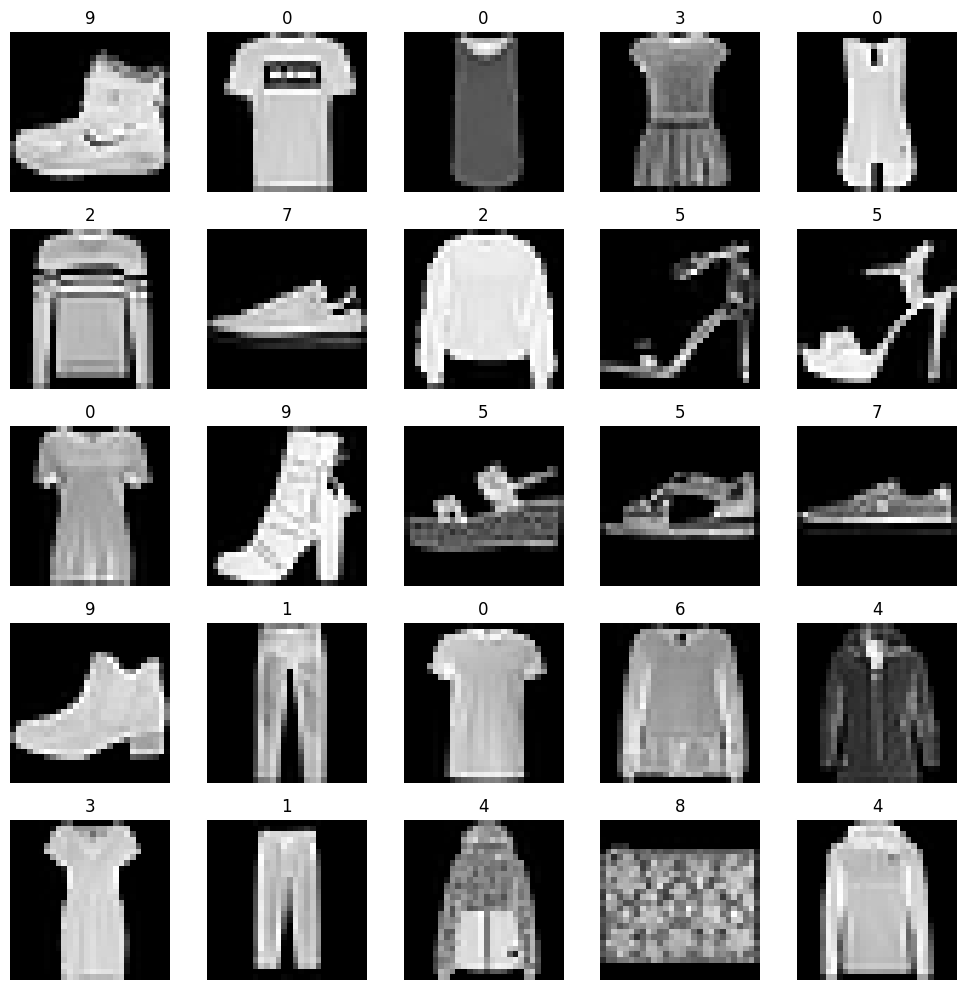

In [11]:
sbplt(5,5,train_data, train_labels)

## Generator

In [12]:
noise_dim = 100

def build_generator():
    model = models.Sequential(name = 'generator')
    model.add(layers.Dense(128*7*7, activation='relu', input_shape=(noise_dim,)))
    model.add(layers.Reshape((7,7,128)))
    model.add(layers.UpSampling2D())
    model.add(layers.BatchNormalization(momentum=0.9))

    model.add(layers.Conv2D(128, activation='relu',padding='same', kernel_size=(3,3)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.UpSampling2D())

    model.add(layers.Conv2D(64, activation='relu',padding='same', kernel_size=(3,3)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Conv2D(1, activation='tanh',padding='same', kernel_size=(3,3), name = 'output_layer'))

    return model

generator = build_generator()
generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv2D)           │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,705 (3.27 MB)

 Trainable params: 856,065 (3.27 MB)

 Non-trainable params: 640 (2.50 KB)

## Discriminator

In [13]:
input_shape = (28,28,1)

def build_discriminator():

    model = models.Sequential(name = 'discriminator')
    model.add(layers.Conv2D(filters = 32,
                            kernel_size=(3,3),
                            strides=(2,2),
                            activation=layers.LeakyReLU(0.2),
                            kernel_initializer = 'he_uniform',
                            padding='same',
                            input_shape = input_shape))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters = 64,
                          kernel_size=(3,3),
                          strides=(2,2),
                          kernel_initializer = 'he_uniform',
                          padding='same',
                          input_shape = input_shape))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters = 128,
                          kernel_size=(3,3),
                          strides=(2,2),
                          kernel_initializer = 'he_uniform',
                          padding='same',
                          input_shape = input_shape))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters = 256,
                          kernel_size=(3,3),
                          strides=(2,2),
                          kernel_initializer = 'he_uniform',
                          padding='same',
                          input_shape = input_shape))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation ='sigmoid', name = 'output_layer'))

    return model

discriminator = build_discriminator()
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,657 (1.49 MB)

 Trainable params: 389,761 (1.49 MB)

 Non-trainable params: 896 (3.50 KB)

## Testing for random noises

tf.Tensor([[0.49847984]], shape=(1, 1), dtype=float32)


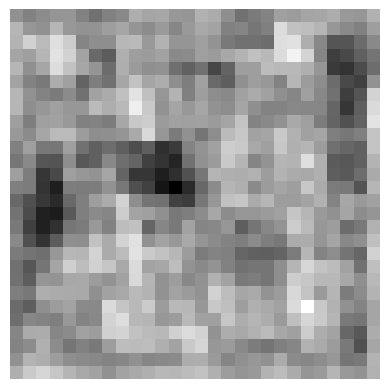

In [14]:
num_samples = 1
noises = tf.random.normal([num_samples, noise_dim])
gen_img = generator(noises, training = False)
plt.imshow(gen_img[0,:,:,0]*127.5 + 127.5, cmap = 'gray')
plt.axis('off')
print(discriminator(gen_img, training = False))
plt.show()

## Optimizers for Generator and Discriminator

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5)

## Loss functions of Generator and Discriminator

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Training

In [19]:
noise_dim = noise_dim
batch_size = batch_size

print(f"batch_size = {batch_size}")
print(f"noise_dim = {noise_dim}")

batch_size = 256
noise_dim = 100


In [20]:
@tf.function

def train_step (real_images):
  
  noise = tf.random.normal([batch_size, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)
    fake_outputs = discriminator(generated_images, training  = True)
    real_outputs = discriminator(real_images, training = True)
    
    gen_loss = generator_loss(fake_outputs)
    disc_loss = discriminator_loss(real_output = real_outputs, fake_output = fake_outputs)
    
  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
  
  return disc_loss, gen_loss
    

In [21]:
# Test generator on following noises throughout training
num_samples = 16
test_noises = tf.random.normal([num_samples,noise_dim])

In [22]:
def generate_and_save_image(model, epoch, test_input):
    rows = 4
    cols = 4
    
    plt.figure(figsize=(rows*2, cols*2))
    plt.suptitle(f"Epoch = {epoch}")
    
    generated_images = model(test_input)
    
    for i in range(rows * cols):
        ax = plt.subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    
    plt.tight_layout()  
    
    if not os.path.exists("images"):
        os.makedirs("images")
    
    plt.savefig(f"images/image-at-epoch-{epoch:04d}.png") 
    plt.show()


In [23]:
import os

# Define checkpoint directory and checkpoint prefix
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


# Restore the latest checkpoint if available
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Checkpoint restored:", latest_checkpoint)

In [24]:
def train(dataset, epochs):
    disc_losses = []
    gen_losses = []

    for epoch in range(1, epochs + 1):
        start = time.time()

        for real_image_batch in dataset:
            disc_loss, gen_loss = train_step(real_image_batch)
        
        disc_losses.append(disc_loss)
        gen_losses.append(gen_loss)
        
        display.clear_output(wait=True)
        print(f"Epoch = {epoch}, disc_loss = {disc_loss}, gen_loss = {gen_loss}, time_taken = {time.time() - start} seconds")
        generate_and_save_image(model=generator, epoch=epoch, test_input=test_noises)

        if epoch % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"checkpoint saved for epoch = {epoch}")

        history = {
            'discriminator_losses': disc_losses,
            'generator_losses': gen_losses
        }

        print(f"history of epoch = {epoch} saved")
        print(f"epoch = {epoch+1} started")
    
    return history

Epoch = 100, disc_loss = 0.3418451249599457, gen_loss = 0.4162862300872803, time_taken = 11.435777425765991 seconds


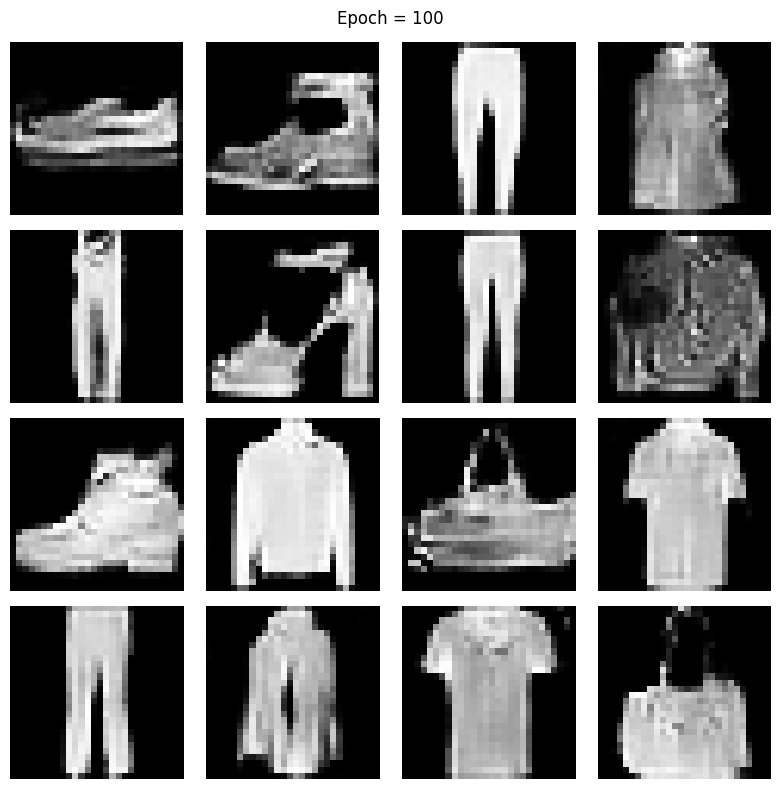

checkpoint saved for epoch = 100
history of epoch = 100 saved
epoch = 100 started


In [25]:
epochs = 100
history = train(batched_train_data, epochs = epochs)

In [26]:
import os
import pickle

# Ensure the output directory exists
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Save the history object to the output directory
output_path = os.path.join(output_dir, 'dcgan-fashion-mnist-history-loss-mse.pkl')
with open(output_path, 'wb') as pickle_file:
    pickle.dump(history, pickle_file)


In [28]:
# Load the history from the pickle file
with open('dcgan-fashion-mnist-history-loss-mse.pkl', 'rb') as pickle_file:
    loaded_history_pickle = pickle.load(pickle_file)

# Access the loaded history
discriminator_losses = loaded_history_pickle['discriminator_losses']
generator_losses = loaded_history_pickle['generator_losses']

In [29]:
generator.save("generator-fashion-mnist-mse.h5")

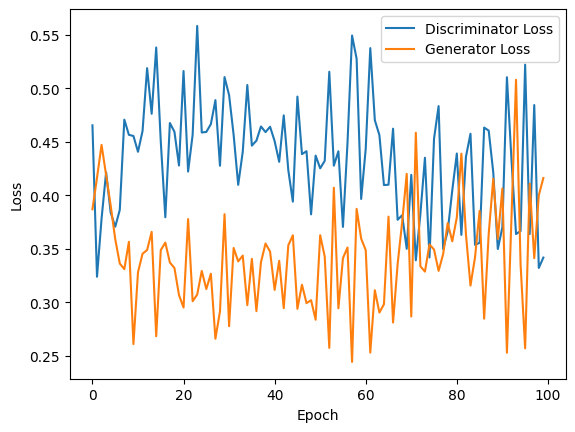

In [30]:
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
import shutil

# Define the directory containing the images and the output zip file
images_dir = '/kaggle/working/images'
output_zip = '/kaggle/working/images-fashion-mnist-mse.zip'

# Zip the directory
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', images_dir)

print(f"Zipped {images_dir} to {output_zip}")


Zipped /kaggle/working/images to /kaggle/working/images-fashion-mnist-mse.zip
